This is the notebook corresponding to arXiv:2504.08033. It is by no means completely optimised, or well-documented. If you find any mistakes or have questions, please contact thomas.spieksma@physics.ox.ac.uk

In [1]:
# Import standard modules
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm
from scipy.interpolate import interp1d
from pathlib import Path

In [2]:
# Import AGN models (needs installation of pAGN, see https://github.com/DariaGangardt/pAGN)
from pagn import Thompson
from pagn import Sirko
import pagn.constants as ct

In [4]:
# Constants 
EPS = 1e-12
LOG_LAMBDA_DEFAULT = 3.0
SIGMA_NORM_THOMPSON = 0.000511905
SPEED_OF_LIGHT = 299792458
Msolar_00 = 1e7   # keep here as default
Mbh = Msolar_00 * ct.MSun

In [5]:
# Generate the data for the accretion disk models, if not already done. The following 2 cells only need to be run once, after that make use of the saved data files
# One shared save function for both disk types
def save_disk(obj, filename):
    R = obj.R
    h = obj.h
    rho = obj.rho
    cs = obj.cs
    np.savetxt(
        filename,
        np.vstack((R/obj.Rs, h/obj.Rs, rho, cs)).T
    )
    print(f"Saved: {filename}")


### Sirko & Goodman 2003 parameters ###
Mbh = 1.000000e+07 MSun
Mdot = 1.298344e-01 MSun/yr
le = 0.5
Rs = 9.570121e-07 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 9.570121e+00 pc
alpha = 0.01
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=45183 (R=3.89e+03 Rs)
Beginning star formation at index 45183
Mdisk = 15468779.099092029 Msun
Mdisk/Mbh = 1.546877909909203


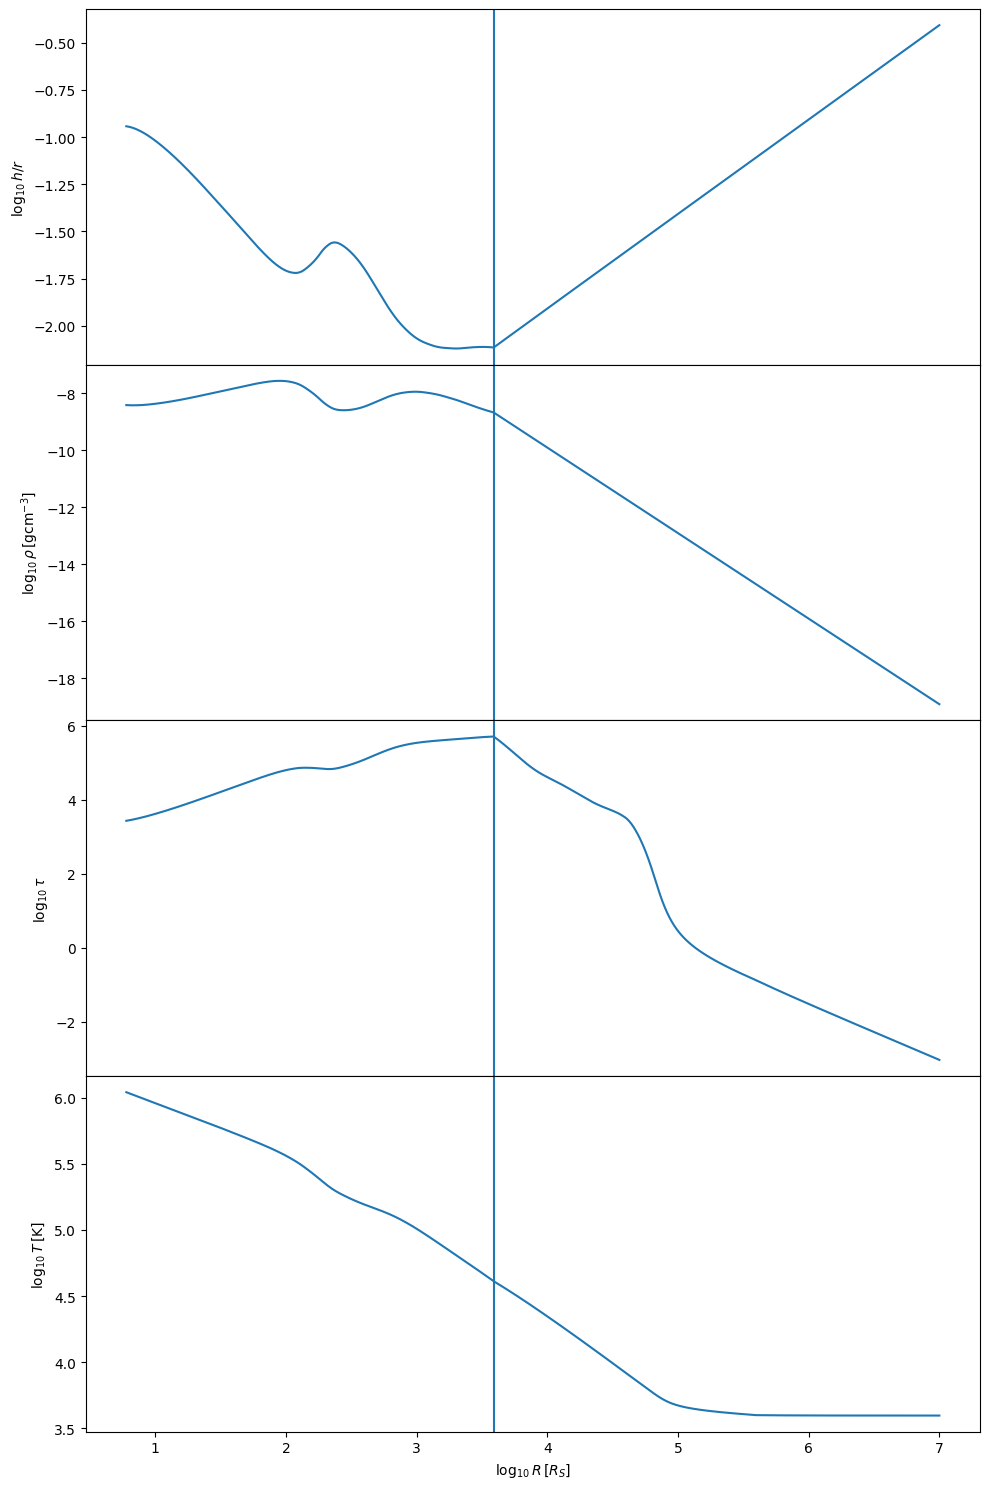

Saved: SG_disk_alpha_MBH1e7


In [4]:
def build_sg_disk():
    le = 0.5
    alpha_00 = 0.01
    X = 0.7
    b = 0
    opacity = "combined"

    sk = Sirko.SirkoAGN(
        Mbh=Mbh, le=le, Mdot=None,
        alpha=alpha_00, X=X, b=b,
        opacity=opacity
    )
    sk.solve_disk(N=1e5)
    return sk

# Run & save SG
sk = build_sg_disk()
sk.plot()
save_disk(sk, "SG_disk_alpha_MBH1e7")

sigma from M using M-sigma relation
### Thompson et al. 2005 parameters ###
Mbh = 1.000000e+07 MSun
Mdot_out = 1.088036e+01 MSun/yr
Rs = 9.570121e-07 pc
Rin = 3.000000e+00 Rs
Rout = 1.000000e+07 Rs = 9.570121e+00 pc
sigma = 1.092213e+02 km/s
epsilon =  0.001
m =  0.2
xi =  1.0
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
 ### Beginning integration at Rmax ###
### Switching to no star formation regime at i = 688728, R = 93242.46552492915Rs ###
Mdisk = 23874005.787212614 Msun
Mdisk/Mbh = 2.3874005787212615


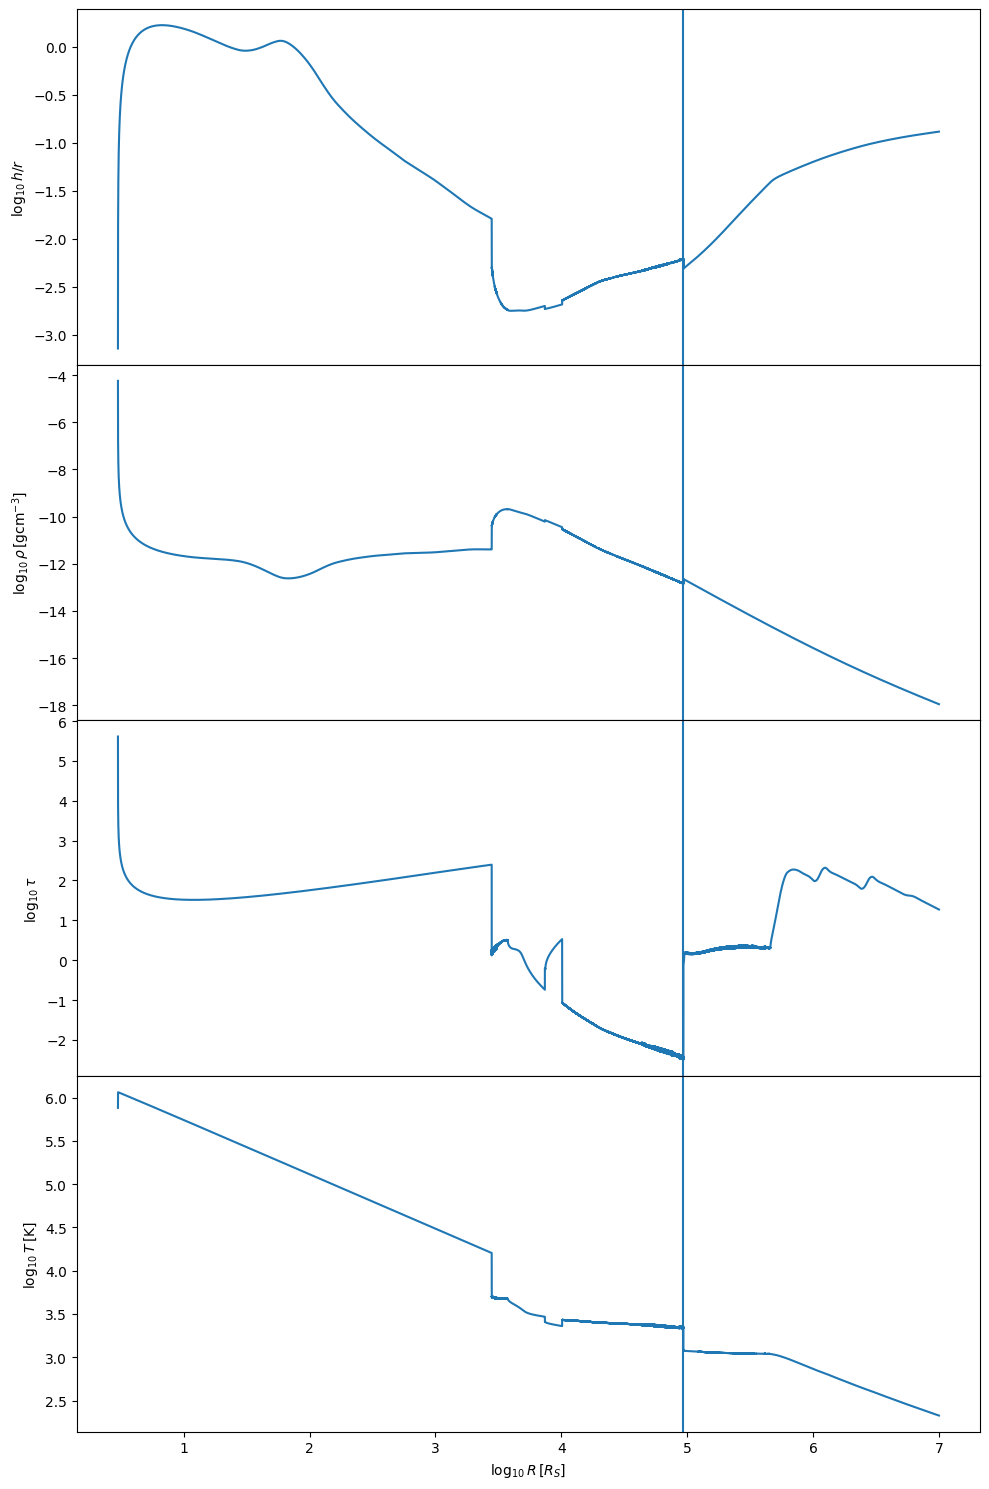

Saved: Tho_disk_alpha_MBH1e7


In [5]:
# This one may take a bit longer to run
def build_tho_disk():
    sigma = None
    epsilon = 1e-3
    m = 0.2
    xi = 1.0
    opacity = "combined"

    tho = Thompson.ThompsonAGN(
        Mbh=Mbh, sigma=sigma,
        epsilon=epsilon, m=m, xi=xi,
        Mdot_out=None, Rout=None, Rin=None,
        opacity=opacity
    )
    tho.solve_disk(N=1e6)
    return tho

# Run & save Thompson
tho = build_tho_disk()
tho.plot()
save_disk(tho, "Tho_disk_alpha_MBH1e7")

In [ ]:
# ---- Disk Selection / load ----
DISK = "SG"   # "SG" or "Tho"
print(f"Using disk model: {DISK}")

disk_files = {
    "SG": Path("SG_disk_alpha_MBH1e7"),
    "Tho": Path("Tho_disk_alpha_MBH1e7"),
}

fn = disk_files[DISK]
if not fn.exists():
    raise FileNotFoundError(f"Disk data file not found: {fn}. Run the build_*_disk cells or place the file here.")

data = np.genfromtxt(str(fn))
if data.ndim != 2 or data.shape[1] < 4:
    raise ValueError(f"Unexpected disk file shape for {fn}: {data.shape}")

r_vals = 2.0 * data[:, 0]  # x-axis for interpolation
disk_height_from_data = data[:, 1] * 2.0
rho_from_data = data[:, 2] * 1.6188e-21 * (Msolar_00**2)
cs_from_data = data[:, 3] / SPEED_OF_LIGHT

#  allow extrapolation
interp_kwargs = dict(bounds_error=False, fill_value="extrapolate")
disk_height_interp = interp1d(r_vals, disk_height_from_data, **interp_kwargs)
rho_interp = interp1d(r_vals, rho_from_data, **interp_kwargs)
cs_interp = interp1d(r_vals, cs_from_data, **interp_kwargs)

Using disk model: SG


In [7]:
# Define relevant function, see Section 2 & 3 of the paper

def vd(R: float, MBH: float) -> float:
    """Disk azimuthal speed (prograde) at |R| for chosen DISK."""
    r = abs(R)
    if DISK == "SG":
        return float(np.sqrt(MBH / max(r, EPS)))
    elif DISK == "Tho":
        Omega = np.sqrt(MBH / max(r**3, EPS) + 2.0 * SIGMA_NORM_THOMPSON**2 / max(r**2, EPS))
        return float(Omega * r)
    else:
        raise ValueError(f"Unknown DISK '{DISK}'")

def R_separation(a: float, e: float, theta: float) -> float:
    """
    Separation between two bodies on a Keplerian orbit:
        r = a * (1 - e^2) / (1 + e * cos(theta))
    """
    return a * (1 - e**2) / (1 + e * np.cos(theta))


def v_rel(r: float, v_x: float, v_y: float, v_z: float, MBH: float) -> np.ndarray:
    """Relative velocity between prograde disk flow and secondary."""
    v_disk = vd(r, MBH)
    return np.array([v_disk - v_x, -v_y, -v_z], dtype=float)

def F_BHL(r, ms, rho_disk_data, cs_data, v_x, v_y, v_z, MBH, log_lambda=LOG_LAMBDA_DEFAULT):
    """Dynamical friction vector"""
    vrel_vec = v_rel(r, v_x, v_y, v_z, MBH)
    vrel_mag = max(norm(vrel_vec), EPS)
    cs = max(cs_data, EPS)
    Mach = vrel_mag / cs

    prefactor = 4.0 * np.pi * (ms**2) * rho_disk_data / (vrel_mag**3 + EPS)
    base_force = prefactor * vrel_vec

    if Mach < 1.0:
        mach_clip = np.clip(Mach, 0.0, 0.9999999999)
        analytic_factor = 0.5 * np.log((1 + mach_clip) / (1 - mach_clip)) - mach_clip
        mag_sup = norm(base_force) * log_lambda
        mag_sub = norm(base_force) * analytic_factor
        chosen_mag = min(mag_sup, mag_sub)
        if norm(base_force) < EPS:
            return np.zeros(3, dtype=float)
        return chosen_mag * (base_force / norm(base_force))
    else:
        return base_force * log_lambda

def F_accr(r, ms, rho_disk_data, cs_data, v_x, v_y, v_z, MBH):
    """Accretion force vector"""
    vrel_vec = v_rel(r, v_x, v_y, v_z, MBH)
    denom = max((norm(vrel_vec)**2 + cs_data**2)**1.5, EPS)
    prefactor = 4.0 * np.pi * (ms**2) * rho_disk_data / denom
    v_disk_x = vd(r, MBH)
    return prefactor * np.array([v_disk_x, 0.0, 0.0], dtype=float)

def mass_accreted_new(r, ms, rho_disk_data, cs_data, scale_height_data, v_x, v_y, v_z, MBH):
    """Estimate of mass accreted in a crossing"""
    vrel_sq = max(norm(v_rel(r, v_x, v_y, v_z, MBH))**2, EPS)
    cs_sq = max(cs_data**2, EPS)
    vz_abs = max(abs(v_z), EPS)
    return 4.0 * np.pi * (ms**2) * rho_disk_data * scale_height_data / ((vrel_sq + cs_sq)**1.5 * vz_abs + EPS)


In [11]:
def scatterings(M_0, ms_0, a_0, e_0, iota_0, theta_0, N_0, process="none"):
    """Perform scatterings. Returns lists"""
    M = float(M_0)
    ms = float(ms_0)
    a = float(a_0)
    e = float(e_0)
    incl = float(iota_0)
    theta = float(theta_0)

    # initial geometry & velocities
    y = a * (1 - e**2) / (1 + e * np.cos(theta))
    r_vec = np.array([0.0, y, 0.0])

    vr0 = np.sqrt(M / (a * (1 - e**2))) * e * np.sin(theta)
    vtheta0 = -np.sqrt(M / (a * (1 - e**2))) * (1 + e * np.cos(theta))

    omega0 = -theta
    Omega0 = np.pi / 2.0
    cosO, sinO = np.cos(Omega0), np.sin(Omega0)
    cosw, sinw = np.cos(omega0), np.sin(omega0)
    costh, sinth = np.cos(theta), np.sin(theta)
    cosi = np.cos(incl)

    v_x = (vr0 * costh - vtheta0 * sinth) * (cosO * cosw - sinO * sinw * cosi) + \
          (vr0 * sinth + vtheta0 * costh) * (-cosO * sinw - sinO * cosw * cosi)

    v_y = (vr0 * costh - vtheta0 * sinth) * (sinO * cosw + cosO * sinw * cosi) + \
          (vr0 * sinth + vtheta0 * costh) * (-sinO * sinw + cosO * cosw * cosi)

    v_z = (vr0 * costh - vtheta0 * sinth) * (sinw * np.sin(incl)) + \
          (vr0 * sinth + vtheta0 * costh) * (cosw * np.sin(incl))

    v = np.sqrt(v_x**2 + v_y**2 + v_z**2)

    # diagnostics and initial reconstructions
    a = M * y / (2 * M - y * v**2)
    Ps_ol = ms * np.array([v_x, v_y, v_z])
    Lorb_o_vec = np.cross(np.array([0.0, y, 0.0]), Ps_ol)
    Lorb_o = norm(Lorb_o_vec)
    beta = np.arcsin(-Ps_ol[2] / max(norm(Ps_ol), EPS))
    Eorb_old = norm(Ps_ol)**2 / (2 * ms) - M * ms / max(abs(y), EPS)
    e = np.sqrt(max(0.0, -Lorb_o**2 + a * ms**2 * M)) / (np.sqrt(a * M) * ms)

    acos_arg = (a * (1 - e**2) / (e * y) - 1 / e) if e > 0 else 0.0
    theta = np.arccos(np.clip(acos_arg, -1.0, 1.0))
    incl = np.arccos(-Lorb_o_vec[2] / max(Lorb_o, EPS))

    # initial accretion (scalar)
    if process == "accretion":
        rho_y = float(rho_interp(y)); cs_y = float(cs_interp(y)); H_y = float(disk_height_interp(y))
        deltaM = mass_accreted_new(y, ms, rho_y, cs_y, H_y, v_x, v_y, v_z, M)
    else:
        deltaM = 0.0

    # initialize storage
    mass_primary = [M]; mass_secondary = [ms]; separation = [y]
    vel_x = [v_x]; vel_y = [v_y]; vel_z = [v_z]; velocity = [v]
    semi_major_axis = [a]; eccentricity = [e]; true_anomaly = [theta]
    inclination = [incl]; beta_angle = [beta]; orbital_energy = [Eorb_old]
    orbital_angular_momentum = [Lorb_o]; vector_r = [r_vec.copy()]; Mass_accretion = [deltaM]

    for i in range(1, int(N_0) + 1):
        # next crossing geometry
        sign_cos_theta = -np.sign(np.cos(theta)) if np.cos(theta) != 0 else -1.0
        r_vec = np.array([0.0, y * sign_cos_theta, 0.0])
        P_old = ms * sign_cos_theta * np.array([v_x, v_y, v_z])

        # crossing time
        H = float(disk_height_interp(y)); vz_abs = max(abs(v_z), EPS)
        deltaT = H / vz_abs

        # evaluate local disk properties once
        rho_y = float(rho_interp(y)); cs_y = float(cs_interp(y))

        # choose and compute force once
        if process == "accretion":
            F = F_accr(y, ms, rho_y, cs_y, v_x, v_y, v_z, M)
        elif process == "friction":
            F = F_BHL(y, ms, rho_y, cs_y, v_x, v_y, v_z, M)
        else:
            F = np.zeros(3, dtype=float)

        # momentum update
        Ps_prime = P_old + F * deltaT * sign_cos_theta

        Ps_prime_norm = norm(Ps_prime)
        beta_prime = np.arcsin(-Ps_prime[2] / max(Ps_prime_norm, EPS))
        Lorb_prime_vec = np.cross(r_vec, Ps_prime); Lorb_prime = norm(Lorb_prime_vec)

        # update mass if accretion
        ms_prime = ms + deltaM if process == "accretion" else ms

        # energy check
        Eorb_prime = Ps_prime_norm**2 / (2 * ms_prime) - M * ms_prime / max(abs(r_vec[1]), EPS)
        if Eorb_prime > 0:
            print(f"Orbit becomes unbound at scattering {i}")
            break

        # new velocities and orbital elements
        v_prime_vec = Ps_prime / ms_prime; v_prime = norm(v_prime_vec)
        incl_prime = np.arccos(-Lorb_prime_vec[2] / max(Lorb_prime, EPS))
        a_prime = M * abs(r_vec[1]) / (2 * M - abs(r_vec[1]) * v_prime**2)
        e_prime = np.sqrt(max(0.0, -Lorb_prime**2 + a_prime * ms_prime**2 * M)) / (np.sqrt(max(a_prime * M, EPS)) * ms_prime)

        if e_prime < 1e-15:
            theta_prime = np.pi / 2.0
        else:
            acos_arg2 = (a_prime * (1 - e_prime**2) - abs(r_vec[1])) / (e_prime * abs(r_vec[1]))
            theta_prime = np.arccos(np.clip(acos_arg2, -1.0, 1.0))

        theta_next = np.pi - theta_prime
        y_next = R_separation(a_prime, e_prime, theta_next)
        v_next = np.sqrt(max(M * (2.0 / y_next - 1.0 / a_prime), 0.0))

        sign_factor = -np.sign(np.cos(theta)) if np.cos(theta) != 0 else -1.0
        v_z_new = y * (Ps_prime[2]) / (y_next * ms_prime * sign_factor)
        v_x_new = y * (Ps_prime[0]) / (y_next * ms_prime * sign_factor)
        v_y_new = np.sqrt(max(v_next**2 - v_x_new**2 - v_z_new**2, 0.0))

        # accretion for next crossing
        if process == "accretion":
            rho_next = float(rho_interp(y_next)); cs_next = float(cs_interp(y_next)); H_next = float(disk_height_interp(y_next))
            deltaM_prime = mass_accreted_new(y_next, ms_prime, rho_next, cs_next, H_next, v_x_new, v_y_new, v_z_new, M)
        else:
            deltaM_prime = 0.0

        # update state
        ms, y, v, v_x, v_y, v_z = ms_prime, y_next, v_next, v_x_new, v_y_new, v_z_new
        a, e, theta, incl = a_prime, e_prime, theta_next, incl_prime

        # safety check for the impulse approximation
        eta = 0.1
        threshold = H / (np.pi * eta * max(abs(y), EPS))
        if incl < threshold:
            print(f"Warning: inclination {incl:.3e} < H/(pi eta r) = {threshold:.3e} at scattering {i}. Stopping.")
            break

        deltaM, beta = deltaM_prime, beta_prime

        # store scalars
        mass_primary.append(M); mass_secondary.append(ms); separation.append(y)
        velocity.append(v); vel_x.append(v_x); vel_y.append(v_y); vel_z.append(v_z)
        semi_major_axis.append(a); eccentricity.append(e); true_anomaly.append(theta)
        orbital_energy.append(Eorb_prime); orbital_angular_momentum.append(Lorb_prime)
        inclination.append(incl); beta_angle.append(beta); vector_r.append(r_vec.copy())
        Mass_accretion.append(deltaM)

        if abs(v) >= 1.0:
            print(f"Stopping because |v| >= 1 at scattering {i}")
            break

    # convert numpy scalars to python floats for clean output
    def _to_pylist(lst):
        return [x.item() if isinstance(x, np.generic) else x for x in lst]

    return (
        _to_pylist(mass_primary), _to_pylist(mass_secondary), _to_pylist(separation),
        _to_pylist(velocity), _to_pylist(vel_x), _to_pylist(vel_y), _to_pylist(vel_z),
        _to_pylist(semi_major_axis), _to_pylist(eccentricity), _to_pylist(true_anomaly),
        vector_r, _to_pylist(orbital_energy), _to_pylist(inclination), _to_pylist(beta_angle),
        _to_pylist(Mass_accretion)
    )


In [29]:
# --- Set initial conditions ---
M_00 = 1                     # Mass of primary (in your code units)
ms_00 = 1e-4 * M_00          # Mass of secondary
process_00 = "friction"      # or "accretion"
a_00 = 1e6 * M_00            # Semi-major axis
e_00 = 0.50                  # Eccentricity
iota_00 = 1 * np.pi / 3      # Inclination
theta_00 = np.pi / 3         # True anomaly
N_00 = 20000                 # Number of scatterings

In [30]:
mass_primary, mass_secondary, separation, velocity, vel_x, vel_y, vel_z, \
semi_major_axis, eccentricity, true_anomaly, vector_r, orbital_energy, \
inclination, beta_angle, Mass_accretion = scatterings(
    M_00, ms_00, a_00, e_00, iota_00, theta_00, N_00,
    process=process_00
)

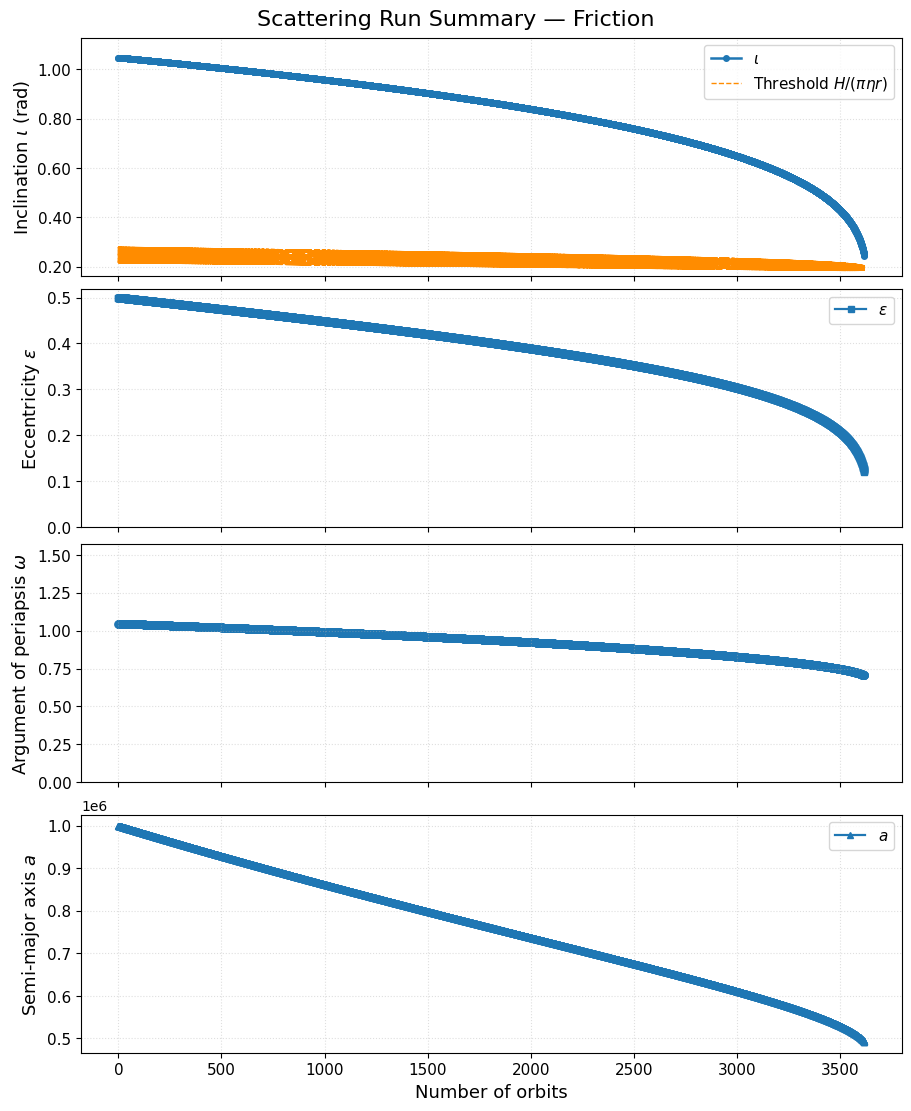

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MaxNLocator

# -------------------------
# Parameters for plotting
# -------------------------
eta = 0.1                     # perturbative parameter used in threshold (Use same as in scattering function)
pad_frac = 0.10               # y-axis padding fraction
stop_idx = len(true_anomaly) - 1
n = len(true_anomaly)
x = np.arange(n)/2

# -------------------------
# Compute threshold H/(pi * eta * r)
# For each saved separation value we compute the threshold
# -------------------------
H_vals = np.empty(n)
threshold_vals = np.empty(n)
for i, r_val in enumerate(separation):
    try:
        H = float(disk_height_interp(r_val))      # ensure scalar
    except Exception:
        # fallback: small value so threshold is tiny and doesn't hide plot
        H = 0.0
    H_vals[i] = H
    threshold_vals[i] = H / (np.pi * eta * max(abs(r_val), 1e-30))

# -------------------------
# Choose reasonable y-limits for inclination
# -------------------------
incl_arr = np.array(inclination, dtype=float)
ymin = np.nanmin(incl_arr)
ymax = np.nanmax(incl_arr)
yrange = max(ymax - ymin, 1e-6)   # avoid zero range
ymin_plot = ymin - pad_frac * yrange
ymax_plot = ymax + pad_frac * yrange

# If threshold is larger than data, extend y-limits so it is visible
ymin_plot = min(ymin_plot, np.nanmin(threshold_vals))
ymax_plot = max(ymax_plot, np.nanmax(threshold_vals))

def smart_pi_formatter_factory(arr):
    """Return a formatter that uses pi multiples if values are in [0, pi] scale."""
    amin, amax = np.nanmin(arr), np.nanmax(arr)
    # Use pi formatter when values fall mostly in [0, pi] or comparable range
    if amax <= 1.05 * np.pi and amin >= -0.05 * np.pi:
        def fmt(x, pos):
            # pick a few canonical labels
            if np.isclose(x, 0):
                return "0"
            frac = x / np.pi
            # nice fractions for common values
            if np.isclose(frac, 0.5):
                return r'$\pi/2$'
            if np.isclose(frac, 0.25):
                return r'$\pi/4$'
            if np.isclose(frac, 0.75):
                return r'$3\pi/4$'
            if np.isclose(frac, 1.0):
                return r'$\pi$'
            # otherwise a numeric with 2 decimals
            return f"{x:.2f}"
        return fmt
    else:
        # fallback: plain numeric formatter
        return lambda x, pos: f"{x:.3g}"

process_label = "Accretion" if process_00.lower().startswith("a") else "Friction"

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex=True, figsize=(9, 11), constrained_layout=True)

# (1) Inclination with threshold band
ax1.plot(x, incl_arr, linewidth=1.8, marker='o', markersize=4, label=r'$\iota$')
# also plot the threshold line
ax1.plot(x, threshold_vals, color='darkorange', linestyle='--', linewidth=1.0, label=r'Threshold $H/(\pi\eta r)$')

ax1.set_ylim(ymin_plot, ymax_plot)
ax1.set_ylabel(r'Inclination $\iota$ (rad)', fontsize=13)
ax1.grid(alpha=0.4, linestyle=':')
ax1.legend(fontsize=11, loc='upper right')
ax1.yaxis.set_major_formatter(FuncFormatter(smart_pi_formatter_factory(incl_arr)))
ax1.tick_params(labelsize=11)

# (2) Eccentricity
ax2.plot(x, eccentricity, linewidth=1.6, marker='s', markersize=4, label=r'$\varepsilon$')
ax2.set_ylabel(r'Eccentricity $\varepsilon$', fontsize=13)
ax2.grid(alpha=0.4, linestyle=':')
ax2.legend(fontsize=11)
ax2.set_ylim(bottom=0)   # eccentricity non-negative
ax2.tick_params(labelsize=11)

# (3) True anomaly
ax3.scatter(x, true_anomaly, s=28, marker='o')
ax3.set_ylim(0, np.pi/2)
ax3.set_ylabel(r'Argument of periapsis $\omega$', fontsize=13)
ax3.grid(alpha=0.4, linestyle=':')
ax3.yaxis.set_major_formatter(FuncFormatter(lambda xx, pos: (r'$\pi/2$' if np.isclose(xx, np.pi/2) else (r'$\pi/4$' if np.isclose(xx, np.pi/4) else f"{xx:.2f}"))))
ax3.tick_params(labelsize=11)

# (4) Semi-major axis w
a_arr = np.array(semi_major_axis, dtype=float)
ax4.plot(x, a_arr, linewidth=1.6, marker='^', markersize=4, label=r'$a$')
ax4.set_ylabel(r'Semi-major axis $a$', fontsize=13)
ax4.set_xlabel('Number of orbits', fontsize=13)
ax4.grid(alpha=0.4, linestyle=':')
if np.nanmax(a_arr) / max(np.nanmin(a_arr[np.nonzero(a_arr)] if np.any(a_arr) else [1e-30]), 1e-30) > 100:
    ax4.set_yscale('log')
ax4.tick_params(labelsize=11)
ax4.legend(fontsize=11)

fig.suptitle(f"Scattering Run Summary — {process_label}", fontsize=16)
plt.show()
